In [1]:
import numpy as np 
from PIL import Image 
import os
import matplotlib.pyplot as plt
import scipy as sp
import scipy.stats
import torch as T 
import torch.nn as nn 
import torch.nn.functional as F 
from torch.utils.data import Dataset, DataLoader 
import torchvision.transforms as trans 
import time 

# Global Variable

In [2]:
path_train = '/home/wwang/datasets/mini_imagenet/train/'
path_val = '/home/wwang/datasets/mini_imagenet/val/'
way = 5
shot = 5
image_size = [84, 84]
dim_embedding = 256
channel = 64
iterations = 1000000
batch_size = 32
path_work = "/home/wwang/wwfewshot/work/prototypicalnet/"
device = T.device("cuda:0")

# Data

In [3]:
class Dataset_siamesenet(Dataset):
    #
    def __init__(self, path):
        category_names = os.listdir(path)
        self.image_list = []
        self.label_list = []
        for label, category_name in enumerate(category_names):
            file_names = os.listdir(path + category_name)
            for file_name in file_names:
                self.image_list.append(path + category_name + '/' + file_name)
                self.label_list.append(label) 
        self.category_num = label + 1
        self.transform = trans.Compose([trans.Resize(image_size, Image.BICUBIC),
                                        trans.RandomHorizontalFlip(),
                                        trans.ToTensor(),
                                        trans.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                        ])
    #
    def __getitem__(self, idx):
        label = np.zeros([way])
        permutation = np.random.permutation(self.category_num)[:way]
        category_random = np.random.randint(way)
        label[category_random] = 1
        image_support = []
        for i, cls in enumerate(permutation):
            ids_per_cls = np.argwhere(np.array(self.label_list) == cls).reshape([-1])
            ids_per_cls = np.random.choice(ids_per_cls, shot+1)
            for j in range(shot):
                image_support.append(self.transform(Image.open(self.image_list[ids_per_cls[j]])))
            if i == category_random:
                image_query = self.transform(Image.open(self.image_list[ids_per_cls[shot]]))
        image_support = T.cat(image_support)
        return image_support, image_query, label
    #
    def __len__(self):
        return iterations

# Network Structure

In [4]:
class CNA(nn.Module):
    #
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
    #
    def forward(self, x):
        return self.layers(x)

In [5]:
class BackBone(nn.Module):
    #
    def __init__(self, channel, dim_embedding):
        super().__init__()
        self.dim_embedding = dim_embedding
        self.layers = nn.Sequential(
            CNA(3, channel, 5, 1, 0), # 84 to 80
            CNA(channel, channel*2, 2, 2, 0), # 80 to 40
            CNA(channel*2, channel*2, 5, 1, 0), # 40 to 36
            CNA(channel*2, channel*4, 2, 2, 0), # 36 to 18
            CNA(channel*4, channel*4, 5, 1, 0), # 18 to 14
            CNA(channel*4, channel*8, 2, 2, 0), # 14 to 7
            nn.Conv2d(channel*8, dim_embedding, 5, 1, 0) # 7 to 3
        )
    #
    def forward(self, x):
        return self.layers(x)

In [6]:
class PrototypicalNet(nn.Module):
    #
    def __init__(self):
        super().__init__()
        self.backbone = BackBone(channel, dim_embedding)
        # self.backbone = resnet18(pretrained=False, num_classes=dim_embedding)
    #
    def forward(self, image_support, image_query): # (batchsize, way*shot, 3, 224, 224) (batchsize, 3, 224, 224) ..(1, way) (1, way+1)
        #
        batch_size = image_support.shape[0]
        image_support = image_support.reshape([batch_size*way*shot, 3, image_size[0], image_size[1]])
        #
        embedding_support = self.backbone(image_support)
        embedding_query = self.backbone(image_query)
        #
        embedding_support = embedding_support.reshape([batch_size, way, shot, dim_embedding, 3, 3])
        embedding_support_avg = T.mean(embedding_support, axis=2)
        embedding_query = embedding_query.reshape([batch_size, 1, dim_embedding, 3, 3])
        #
        distance = T.mean((embedding_support_avg - embedding_query)**2, axis=[2,3,4])
        # score = F.softmax(-distance, 1)
        score = -distance
        return score


# Show

In [7]:
@ T.no_grad()
def show(net, path):
    #
    dataloader = DataLoader(Dataset_siamesenet(path=path), batch_size=1)
    for image_support, image_query, label in dataloader:
        break
    image_support = image_support.reshape([-1, way*shot, 3, image_size[0], image_size[1]])
    #
    plt.figure(figsize=(10, 15))
    for i in range(way*shot+1):
        plt.subplot(way+1, shot, i+1)
        if i < way*shot:
            image = image_support[0, i, :, :, :].cpu().numpy().transpose([1,2,0])
            plt.title('Support. Label: {}'.format(int(label[0, i//shot])))
        else:
            image = image_query[0, :, :, :].cpu().numpy().transpose([1,2,0])
            plt.title('Query')
        plt.imshow(image*0.5+0.5)
    plt.show()
    #
    if net is not None:
        net.eval()
        image_support, image_query = image_support.to(device), image_query.to(device)
        score = net(image_support, image_query).softmax(1)
        print('score: {}'.format(score.cpu().numpy()))

/home/wwang/anaconda3/envs/pytorch/lib/python3.9/site-packages/torchvision/transforms/transforms.py:287: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


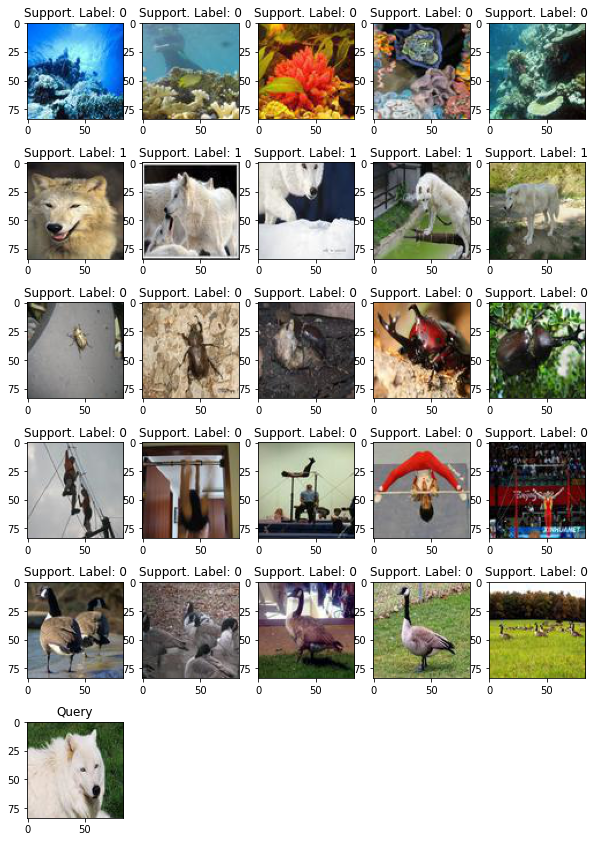

score: [[0.19999999 0.20000003 0.19999997 0.19999997 0.19999997]]


In [8]:
net = PrototypicalNet().to(device)
show(net, path_val)

In [9]:
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0*np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * sp.stats.t._ppf((1+confidence)/2., n-1)
    return m,h


@ T.no_grad()
def test(net, path, episode, batch_size=15):
    net.eval()
    dataloader = DataLoader(Dataset_siamesenet(path=path), batch_size=batch_size)
    accuracies = []
    for i, (image_support, image_query, label_relative) in enumerate(dataloader):
        if i == episode:
            break
        image_support, image_query = image_support.to(device), image_query.to(device)
        score = net(image_support, image_query)
        accuracy = np.mean( score.cpu().numpy().argmax(1) == label_relative.numpy().argmax(1) )
        accuracies.append(accuracy)
    test_accuracy, h = mean_confidence_interval(accuracies)
    return test_accuracy, h


# net = PrototypicalNet().to(device)
# test_accuracy, h = test(net, path_val, episode=600, batch_size=15)
# print("val accuracy:", test_accuracy, "h:", h)

# Training

In [10]:
def trainer(image_supportset, image_queryset, label_relative, net, optimizer):
    #
    y = net(image_supportset, image_queryset)
    #
    loss = F.cross_entropy(y, label_relative)
    #
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss

In [11]:
def train(iterations, load_model):
    #
    iteration = np.load(path_work + 'iteration.npy', allow_pickle=True).item() if load_model else 0
    print('Start training from iteration ', str(iteration))
    net = PrototypicalNet().to(device)
    optimizer = T.optim.Adam(net.parameters(), 1e-4)
    if load_model:
        net.load_state_dict(T.load(path_work + 'net.pt'))
        optimizer.load_state_dict(T.load(path_work + 'optimizer.pt'))
    #
    dataloader = DataLoader(Dataset_siamesenet(path=path_train), batch_size=batch_size)
    time_start = time.time()
    for image_support, image_query, label_relative in dataloader:
        if iteration == iterations:
            break
        iteration += 1
        image_support, image_query, label_relative = image_support.to(device), image_query.to(device), label_relative.to(device)
        loss = trainer(image_support, image_query, label_relative, net, optimizer)
    #
        if(iteration % 100 == 0):
            print('Iteration: {}, loss: {}'.format(iteration, loss.detach().cpu().numpy().item()))  
            T.save(net.state_dict(), path_work + 'net.pt')
            T.save(net.state_dict(), path_work + 'net_backup.pt')
            T.save(optimizer.state_dict(), path_work + 'optimizer.pt')
            T.save(optimizer.state_dict(), path_work + 'optimizer_backup.pt')
            np.save(path_work + 'iteration.npy', iteration) 
            show(net, path_val)
            print('These iterations cost {} seconds'.format(time.time() - time_start))
            time_start = time.time()
        if(iteration % 100000 == 0):
            test_accuracy, h = test(net, path_val, episode=600, batchsize=15)
            print("val accuracy:", test_accuracy, "h:", h)

In [12]:
# train(iterations=1000, load_model=False)

In [13]:
# train(iterations=iterations, load_model=True)

# Test

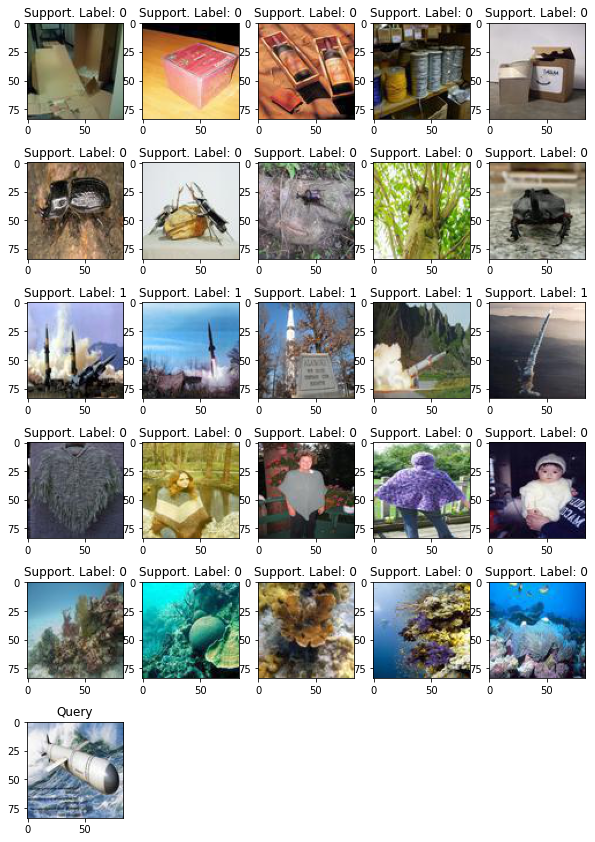

score: [[0.04249785 0.06319414 0.3786544  0.33083913 0.1848145 ]]


In [14]:
net = PrototypicalNet().to(device)
net.load_state_dict(T.load(path_work + 'net.pt'))
show(net, path_val)

In [15]:
total_episode = 10
total_accuracy = 0.0
for _ in range(total_episode):
    test_accuracy, h = test(net, path_val, episode=600, batch_size=15)
    print("test accuracy:", test_accuracy, "h:", h)
    total_accuracy += test_accuracy
print("aver_accuracy:",total_accuracy/total_episode)

test accuracy: 0.5077777777777778 h: 0.010368289261908083


KeyboardInterrupt: 